###### feature set 8 chromosomes 5, 6, 7 + unknown

## In this notebook:

* single input dataframe 
* using feature set 8
* random forest
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.76
* feature importance for RF (mostly just amino acid position)

In [8]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr5-7_unk_featureset8_curr.pkl")



print("shape before", df.shape)
# df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]


#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

# df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (22717, 15)
shape after dropping all data with score = '.' (22717, 15)
shape after dropping Unk (22717, 15)


aapos  codonpos  MutationTaster_score  \
chr pos    ref alt                                          
5   156173 C   T      415         1              0.999355   
    161930 G   A      879         1              1.000000   
    171224 G   A     1277         2              0.999839   
    218356 A   C        1         1              1.000000   
               G        1         1              1.000000   

                    fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos    ref alt                                                       
5   156173 C   T                  0.159257          0.999570         0   
    161930 G   A                  0.056152          0.999986         0   
    171224 G   A                  0.038730          0.999642         0   
    218356 A   C                  0.026135          1.000000         0   
               G                  0.022498          1.000000         0   

                    RVIS_ExAC  ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos    ref alt                                                           
5   156173 C   T     2.023531       -2.471628                     0.002396   
    161930 G   A     2.023531       -2.471628                     0.002396   
    171224 G   A     2.023531       -2.471628                     0.002396   
    218356 A   C    -0.651594       -2.471628                     0.000799   
               G    -0.651594       -2.471628                     0.000799   

                    Problematic  Mutation<1kb  Mutation<5kb  Mutation<10kb  \
chr pos    ref alt                                                           
5   156173 C   T              0             1             1              2   
    161930 G   A              2             1             1              3   
    171224 G   A              2             1             1              2   
    218356 A   C              1            18            18            125   
               G              1            18            18            125   

                    Mutation<30kb  Mutation<100kb  
chr pos    ref alt                                 
5   156173 C   T                3             352  
    161930 G   A                3             376  
    171224 G   A                3             376  
    218356 A   C              276             376  
               G              276             376

In [9]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos  codonpos  MutationTaster_score  \
chr pos       ref alt                                          
5   59193502  G   C      164         1              0.999836   
7   140778053 C   A      485         3              1.000000   
5   33954361  C   A      236         1              1.000000   

                       fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos       ref alt                                                       
5   59193502  G   C                  0.859064          1.000000         0   
7   140778053 C   A                  0.649139          0.996133         0   
5   33954361  C   A                  0.958821          1.000000         0   

                       RVIS_ExAC  ExAC_cnv.score  SORVA_LOF_MAF0.005_HetOrHom  \
chr pos       ref alt                                                           
5   59193502  G   C    -1.005251        0.055500                     0.006789   
7   140778053 C   A    -0.96

Confusion matrix: 
 [[3425  264   67]
 [ 498  743   16]
 [ 513   26   89]]
Accuracy: 0.7546534302428647
Recall TP/(TP+FN): [0.91187433 0.5910899  0.14171975]
Precision TP/(TP+FP): [0.77209197 0.71926428 0.51744186]
F1: [0.83618164 0.6489083  0.2225    ]
Feature ranking:
1. feature 3 (0.164950)
fathmm-XF_coding_score
2. feature 2 (0.126507)
MutationTaster_score
3. feature 0 (0.105977)
aapos
4. feature 4 (0.076854)
GenoCanyon_score
5. feature 13 (0.074076)
Mutation<100kb
6. feature 12 (0.070552)
Mutation<30kb
7. feature 6 (0.070126)
RVIS_ExAC
8. feature 9 (0.064840)
Mutation<1kb
9. feature 11 (0.063850)
Mutation<10kb
10. feature 10 (0.062914)
Mutation<5kb
11. feature 7 (0.054737)
ExAC_cnv.score
12. feature 8 (0.033361)
SORVA_LOF_MAF0.005_HetOrHom
13. feature 1 (0.031256)
codonpos
14. feature 5 (0.000000)
LINSIGHT


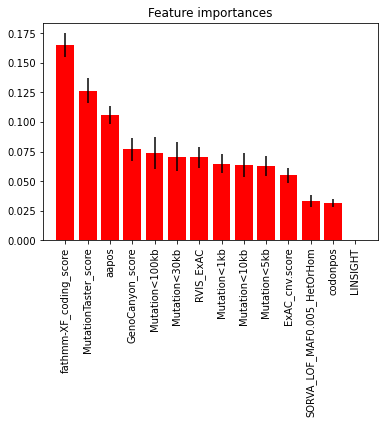

In [10]:
# Try a random forest:

from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(random_state=1, class_weight="balanced")
forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
#ax = plt.gca()
#rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
#plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

In [11]:
print(df_test, y_pred)

                       aapos  codonpos  MutationTaster_score  \
chr pos       ref alt                                          
5   218360    C   T        2         2              0.998408   
    218378    C   G        8         2              0.999987   
    218380    C   G        9         1              0.999997   
    218407    C   G       18         1              1.000000   
    218416    G   A       21         1              1.000000   
...                      ...       ...                   ...   
7   158879714 C   G      202         1              1.000000   
    158879928 A   G      273         2              1.000000   
    158887026 C   T      314         2              0.999997   
    158913079 G   A      562         2              0.999996   
    158945655 C   T     1026         2              1.000000   

                       fathmm-XF_coding_score  GenoCanyon_score  LINSIGHT  \
chr pos       ref alt                                                       
5   218360   